In [30]:
import numpy as np
import pandas as pd
import time
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Input
from keras.models import Model

import gym
import matplotlib.pyplot as plt

ImportError: cannot import name 'Conv2D' from 'keras.layers.core' (/Users/samwilliams/homebrew/lib/python3.7/site-packages/keras/layers/core.py)

In [2]:
def plot_state(obs):
    plt.figure(figsize=(12,8))
    plt.imshow(obs)
    plt.axis("off")
    plt.show()

In [3]:
env = gym.make("Breakout-v0")
init = env.reset()

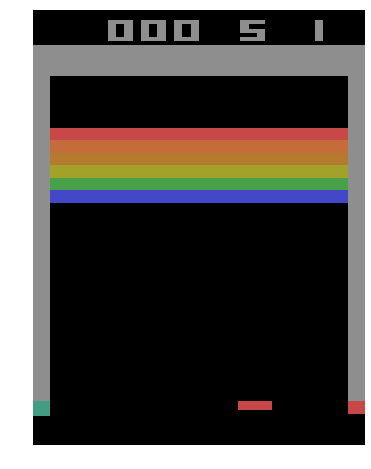

In [4]:
plot_state(init)

In [5]:
init = init.mean(axis=-1,keepdims=1)
init = init.astype('float32') / 255

In [6]:
init.shape

(210, 160, 1)

In [7]:
init[init > 0] = 1

In [8]:
init.max()

1.0

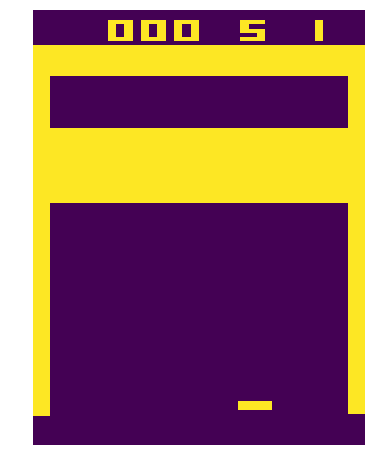

In [9]:
plot_state(init.reshape(210,160))

In [10]:
env.action_space

Discrete(4)

In [11]:
env.observation_space.shape

(210, 160, 3)

In [12]:
inp = Input(shape=init.shape)
x = Flatten()(inp)
x = Dense(516, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(env.action_space.n)(x)

model = Model(inp, output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 210, 160, 1)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 33600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 516)               17338116  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                33088     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,371,464
Trainable params: 17,371,464
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
def process_obs(obs):
    obs = obs.mean(axis=-1,keepdims=1)
    obs = obs.astype('float32') / 255
    obs[obs > 0] = 1
    obs = np.expand_dims(obs,0)
    return obs

In [21]:
env = gym.make("Breakout-v0")
observation = env.reset()
observation = process_obs(observation)


episodes = 2
epsilon = 0.5
gamma = 0.9
done = False
games = 100
history = {}


for i in range(1, games):
    print("Welcome to AI Breakout!")
    print("Starting Game {}...\n".format(i))
    
    history = {"input":[], "reward":[], "action": [], "Q":[]}
    sum = 0
    game = True
    while game:
        
        history["input"].append(observation)
        history["action"].append(None)
        history["reward"].append(0)
        
        if np.random.uniform(0,1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(observation))
            
        observation, reward, done, info = env.step(action)
        
        observation = process_obs(observation)
        
        
        history["input"].append(observation)
        history["action"].append(action)
        history["reward"].append(reward)
        
        sum += reward

        time.sleep(0.02)
        env.render()
        
        if done:
            
            
            Q = []
            for j,k in enumerate(history["reward"][::-1]):
                if j == 0:
                    val = np.array([[0, 0 ,0 ,0]])
                    val[0,history["action"][-1]] = k
                    Q.append(val)
                else:
                    val = np.array([[0, 0 ,0 ,0]])
                    val[0,history["action"][-1-j]] = k + gamma*Q[-1][0].sum()
                    Q.append(val)
            
            Q = np.array(Q[::-1])
            Q = Q.reshape(Q.shape[0],Q.shape[2])
            print(Q)

            history["Q"] = Q 
            
            print("Training the model...")
            
            history["input"] = np.array(history["input"])
            print("shape: ",history["input"].shape)
            history["input"] = history["input"].reshape((history["input"].shape[0],\
                                                         history["input"].shape[2],\
                                                         history["input"].shape[3],\
                                                         history["input"].shape[4]))
            print(history["input"].shape)
            model.fit(history["input"], history["Q"], epochs = 1, batch_size=50)
            
            
            print("Total game score was: {}\n".format(sum))
            
            observation = env.reset()
            observation = process_obs(observation)
            epsilon -= 0.0001
            game = False
                             
        else:
            pass
            
         

Welcome to AI Breakout!
Starting Game 1...

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Training the model...
shape:  (414, 1, 210, 160, 1)
(414, 210, 160, 1)
Epoch 1/1
414/414 [==============================] - 3s 8ms/step - loss: 30.9985 - mean_squared_error: 30.9985
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 2...

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Training the model...
shape:  (326, 1, 210, 160, 1)
(326, 210, 160, 1)
Epoch 1/1
326/326 [==============================] - 2s 6ms/step - loss: 2.1413 - mean_squared_error: 2.1413
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 3...

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Training the model...
shape:  (568, 1, 210, 160, 1)
(568, 210, 160, 1)
Epoch 1/1
568/568 [==============================] - 3s 6ms/step - loss: 0.5558 - mean_squared_error: 0.5558
Total game score was: 2.0

Welcome to AI Breakout!
Start

502/502 [==============================] - 4s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Total game score was: 1.0

Welcome to AI Breakout!
Starting Game 27...

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Training the model...
shape:  (394, 1, 210, 160, 1)
(394, 210, 160, 1)
Epoch 1/1
394/394 [==============================] - 3s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Total game score was: 0.0

Welcome to AI Breakout!
Starting Game 28...

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Training the model...
shape:  (672, 1, 210, 160, 1)
(672, 210, 160, 1)
Epoch 1/1
672/672 [==============================] - 4s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Total game score was: 3.0

Welcome to AI Breakout!
Starting Game 29...

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 ...
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Training the model...
shape:  (542, 1, 210, 160, 1)
(542, 210, 160, 1)
Epoch 1/1
542/542 [===================

KeyboardInterrupt: 

In [ ]:
model.predict(observation)